# Overview
This notebook contains both model that we are using. We first use The TAU model to generate the 22th frame and then use the Masked RCNN v2 model to generate the 22th mask from the frame

## To load the models
Using the following cell to load our model weights for final submission

In [3]:
#Need to upload the work_dirs.zip and rcnn_model weights to Google Colab
!unzip work_dirs.zip #This contains the weights for the TAU model
rcnnmodelfile = './model_epoch_40_loss_10.1821.pth' #This is the weight for the Masked RCNN v2 model

# Model 1 TAU
This notebook is adopted from the OpenSTL Tutorial provided from https://github.com/chengtan9907/OpenSTL/blob/OpenSTL-Lightning/examples/tutorial.ipynb
The TAU model is an advanced neural network architecture designed for efficient and accurate processing of sequential data. It uses a combination of spatial encoders and decoders, interlaced with TAU modules, to handle complex temporal dynamics. This model excels in tasks such as video frame prediction, where understanding the temporal evolution of pixel patterns is crucial. It operates on multi-dimensional data, represented with shape B x T x C x H x W, denoting samples, frames, channels, height, and width, respectively. The TAU model's efficacy is demonstrated through the visualization of predicted frame sequences, showcasing its potential in various applications that require nuanced temporal understanding.

## 0. Setup the environment

In [2]:
!git clone -b OpenSTL https://github.com/chengtan9907/OpenSTL

Cloning into 'OpenSTL'...
remote: Enumerating objects: 2368, done.
remote: Counting objects: 100% (853/853), done.
remote: Compressing objects: 100% (247/247), done.
remote: Total 2368 (delta 703), reused 668 (delta 606), pack-reused 1515
Receiving objects: 100% (2368/2368), 2.24 MiB | 12.54 MiB/s, done.
Resolving deltas: 100% (1715/1715), done.


In [3]:
#uncomment for first time running this notebook
import os
os.chdir('./OpenSTL')

!python setup.py install
os.chdir('..')

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based t

In [4]:
# !pip install opencv-python
# !pip install numpy
# !pip install Pillow
# !pip install pandas

In [5]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [4]:
#To import OpenSTL after installing in Google Colab, need to run this cell to restart the kernel
try:
  import openstl
except ImportError:
  print('Stopping RUNTIME! Please run again.')
  import os
  os.kill(os.getpid(), 9)

In [1]:
#Need to upload the Dataset file to Google Colab
!unzip Dataset_Student.zip

Archive:  Dataset_Student.zip
   creating: Dataset_Student/
   creating: Dataset_Student/test/
   creating: Dataset_Student/test/video_15000/
 extracting: Dataset_Student/test/video_15000/image_0.png  
 extracting: Dataset_Student/test/video_15000/image_1.png  
 extracting: Dataset_Student/test/video_15000/image_10.png  
 extracting: Dataset_Student/test/video_15000/image_2.png  
 extracting: Dataset_Student/test/video_15000/image_3.png  
 extracting: Dataset_Student/test/video_15000/image_4.png  
 extracting: Dataset_Student/test/video_15000/image_5.png  
 extracting: Dataset_Student/test/video_15000/image_6.png  
 extracting: Dataset_Student/test/video_15000/image_7.png  
 extracting: Dataset_Student/test/video_15000/image_8.png  
 extracting: Dataset_Student/test/video_15000/image_9.png  
   creating: Dataset_Student/test/video_15001/
 extracting: Dataset_Student/test/video_15001/image_0.png  
 extracting: Dataset_Student/test/video_15001/image_1.png  
 extracting: Dataset_Student/t

### 1.1 Process and save the dataset
For the dataset, we are using the Dataset_Student_V2.zip provided by the TA. We extracted the zip file into a dir and put this notebook under the folder Dataset_Student_V2. The actually dataset is in dir Dataset_Student_V2/Dataset_Student. We transfer about 8k videos from the unlabeled dataset to make the training set up to 10000 videos. Not all of the video is because we were training on a local machine which memory can only handle up to 10000 videos during data loading.

#### hyperparameters

`pre_seq_length`: the number of given frames

`aft_seq_length`: the number of frames to predict

In [5]:
pre_seq_length = 11
aft_seq_length = 11

In [6]:
import cv2
import numpy as np
import os
import pickle

def load_images(image_folder, num_images=22):
    images = []
    files = sorted(os.listdir(image_folder))[:num_images]  # Assuming the images are named in a sorted manner
    for file in files:
        img_path = os.path.join(image_folder, file)
        if os.path.isfile(img_path) and file.lower().endswith('.png'):
            image = cv2.imread(img_path)
            images.append(image)
    return np.stack(images)

def process_single_video(video_folder, pre_slen=11, aft_slen=11):
    images = load_images(video_folder, pre_slen + aft_slen)
    data = np.expand_dims(images, axis=0).transpose(0, 1, 4, 2, 3)

    if data.max() > 1.0:
        data = data.astype(np.float32) / 255.0

    return data[:, :pre_slen], data[:, pre_slen:]

# Example usage for video folder "video0"
data_x, data_y = process_single_video('./Dataset_Student/train/video_0', pre_slen=pre_seq_length, aft_slen=aft_seq_length)

# Inspect data shapes or further processing
print(f'data_x shape: {data_x.shape}')
print(f'data_y shape: {data_y.shape}')


data_x shape: (1, 11, 3, 160, 240)
data_y shape: (1, 11, 3, 160, 240)


In [7]:
import numpy as np
import os
from PIL import Image
import re

def is_image_file(filename):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    return any(filename.lower().endswith(ext) for ext in valid_extensions)

def extract_number(filename):
    # Extract numbers from the filename
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else 0

def sample_images(folder_path, num_frames=22):
    # Get a list of image files and sort them in numerical order
    files = [f for f in os.listdir(folder_path) if is_image_file(f)]
    files.sort(key=extract_number)
    num_files = len(files)

    # Create frame indices
    if num_files < num_frames:
        # Repeat each index at an interval equal to the number of files
        frame_idxs = [i % num_files for i in range(num_frames)]
    else:
        frame_idxs = np.linspace(0, num_files - 1, num_frames, dtype=int)

    frames = []
    for idx in frame_idxs:
        image_path = os.path.join(folder_path, files[idx])
        try:
            with Image.open(image_path) as frame:
                frame = np.array(frame)  # Convert PIL image to numpy array
                frames.append(frame)
        except IOError:
            print(f"Cannot open image: {image_path}")
            continue

    return np.stack(frames) if frames else np.array([])  # Return an empty array if there are no frames


def process_folder(folder_path, pre_slen=10, aft_slen=10, batch_size=10000):
    subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    processed_count = 0
    batch_count = 0

    for i in range(0, len(subfolders), batch_size):
        batch_subfolders = subfolders[i:i + batch_size]
        sequences = []
        batch_subfolders.sort(key=extract_number)

        for subfolder in batch_subfolders:
            subfolder_path = os.path.join(folder_path, subfolder)
            print(subfolder_path)
            sequence = sample_images(subfolder_path, pre_slen + aft_slen)
            if sequence.shape[0] == pre_slen + aft_slen:
                sequences.append(sequence)
            else:
                print(f"Skipping sequence in {subfolder_path}, expected frames: {pre_slen + aft_slen}, found: {sequence.shape[0]}")

        if sequences:
            data = np.stack(sequences).transpose(0, 1, 4, 2, 3)
            if data.max() > 1.0:
                data = data.astype(np.float32) / 255.0

            pre_data = data[:, :pre_slen]
            post_data = data[:, pre_slen:]

            # Save this batch to a file
            with open(f"processed_data_batch_{batch_count}.pkl", 'wb') as f:
                pickle.dump((pre_data, post_data), f)

            batch_count += 1
            processed_count += len(sequences)

            return pre_data, post_data

    print(f"Processed {processed_count} sequences in {batch_count} batches.")


In [8]:
import pickle

dataset = {}
folders = ['train', 'val', 'test']

for folder in folders:
    data_x, data_y = process_folder('./Dataset_Student/' + folder, pre_slen=pre_seq_length, aft_slen=aft_seq_length)
    dataset['X_' + folder], dataset['Y_' + folder] = data_x, data_y
    print(folder)

# save as a pkl file
with open('dataset_tau.pkl', 'wb') as f:
    pickle.dump(dataset, f)

./Dataset_Student/train/video_0
./Dataset_Student/train/video_1
train
./Dataset_Student/val/video_1000
./Dataset_Student/val/video_1001
val
./Dataset_Student/test/video_15000
./Dataset_Student/test/video_15001
test


## Load the dataset file

In [9]:
import pickle

# load the dataset
with open('dataset_tau.pkl', 'rb') as f:
    dataset = pickle.load(f)


train_x, train_y = dataset['X_test'], dataset['Y_test']

print(train_x.shape)
print(train_y.shape)
# the shape is B x T x C x H x W
# B: the number of samples
# T: the number of frames in each sample
# C, H, W: the height, width, channel of each frame

(2, 11, 3, 160, 240)
(2, 11, 3, 160, 240)


In [10]:
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, X, Y, normalize=False):
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None

        if normalize:
            # get the mean/std values along the channel dimension
            mean = data.mean(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            std = data.std(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            data = (data - mean) / std
            self.mean = mean
            self.std = std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        return data, labels

#### hyperparameters

`batch_size`: the size of a batch

In [11]:
batch_size = 4

In [12]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = dataset['X_train'], dataset['X_val'], dataset['X_test'], dataset['Y_train'], dataset['Y_val'], dataset['Y_test']

train_set = CustomDataset(X=X_train, Y=Y_train)
val_set = CustomDataset(X=X_val, Y=Y_val)
test_set = CustomDataset(X=X_test, Y=Y_test)



In [13]:
dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

## Train and Evaluate

In [14]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 300,
    'lr': 5e-3,
    'drop_path': 0,
    'metrics': ['mse', 'mae'],
    'warmup_epoch': 5,
    'sched':'onecycle',
    'auto_resume': True,

    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [11, 3, 160, 240],
}

custom_model_config = {
#     # For MetaVP models, the most important hyperparameters are:
#     # N_S, N_T, hid_S, hid_T, model_type
    'method': 'TAU',

    # Model configuration
    'model_type': 'tau',
    'N_S': 4,
    'N_T': 8,
    'hid_S': 64,
    'hid_T': 512,
    'spatio_kernel_enc': 3,
    'spatio_kernel_dec': 3,
    'alpha': 0.1,
}

In [15]:
from openstl.api import BaseExperiment
from openstl.utils import create_parser

args = create_parser().parse_args([])
config = args.__dict__

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)

exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_val, dataloader_test))

Use non-distributed mode with GPU: cuda:0
Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_12.2.r12.2/compiler.33191640_0
GPU 0: Tesla T4
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PyTorch: 2.1.0+cu121
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-ge

### Start training and evaluation

In [ ]:
#Skip this block when using an existed model to predict
print('>'*35 + ' training ' + '<'*35)
exp.train()

print('>'*35 + ' testing  ' + '<'*35)
exp.test()

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> training <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
#Run this block only if you are using an existed model to predict
print('>'*35 + ' testing  ' + '<'*35)
exp.test()

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.5 task/s, elapsed: 2s, ETA:     0smse:476.6288146972656, mae:2310.972900390625


476.6288

After running the exp.test(), the predict result of the TAU model is './work_dirs/custom_exp/saved/preds.npy'

## Visualization

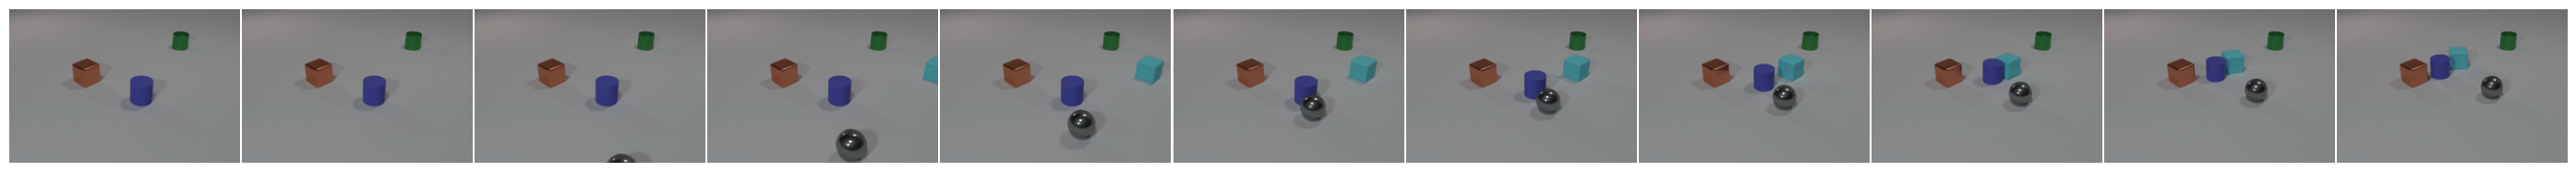

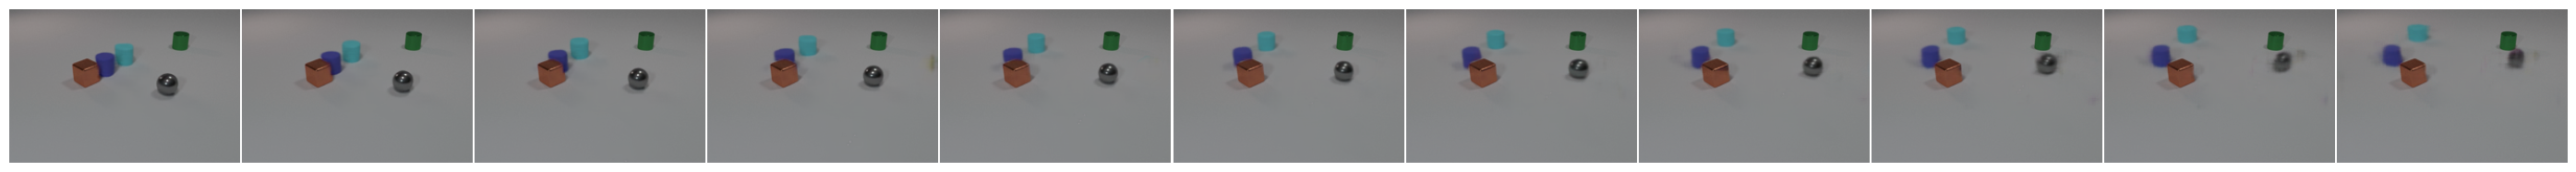

/usr/local/lib/python3.10/dist-packages/OpenSTL-0.3.0-py3.10.egg/openstl/utils/visualization.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))


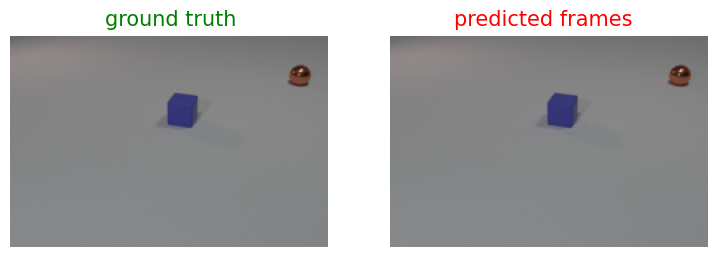

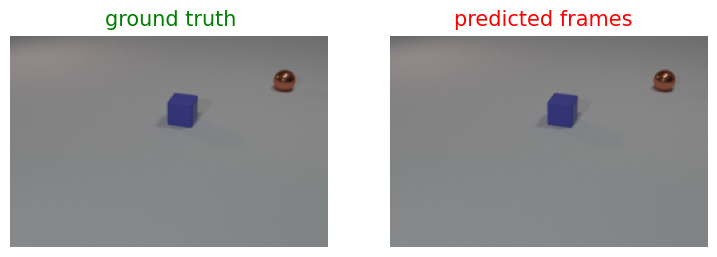

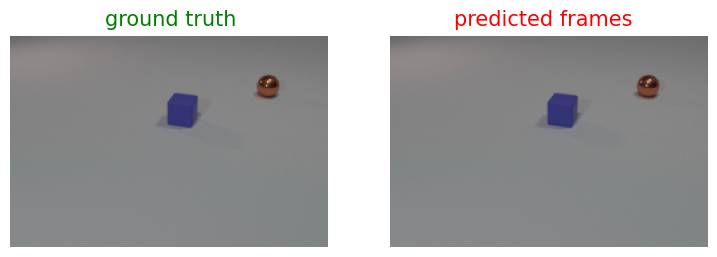

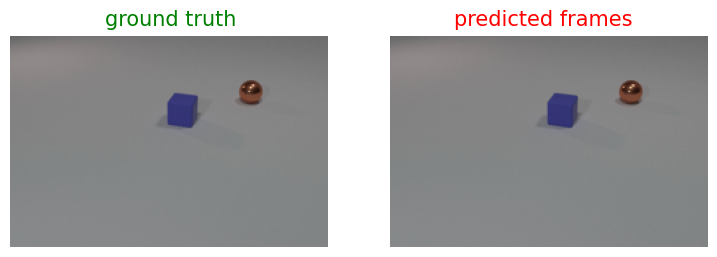

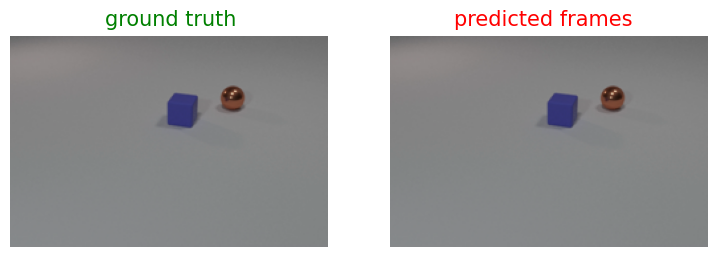

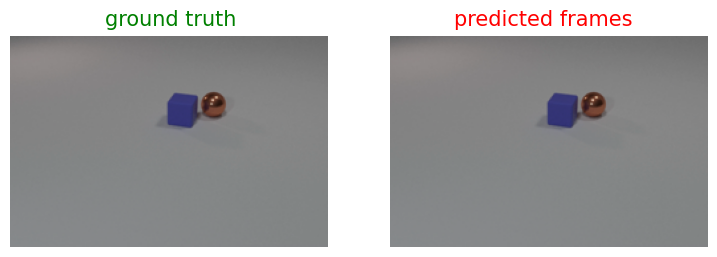

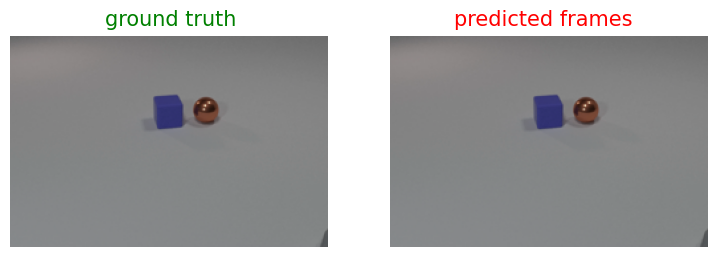

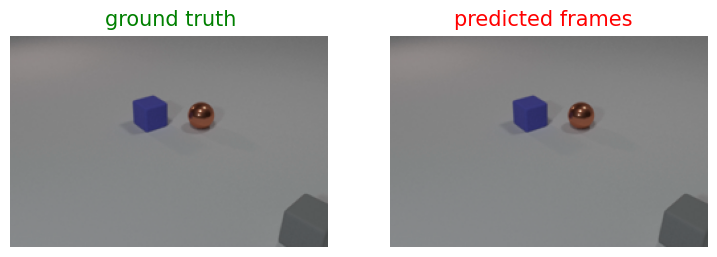

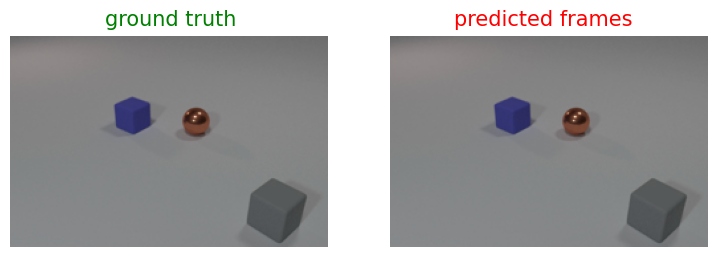

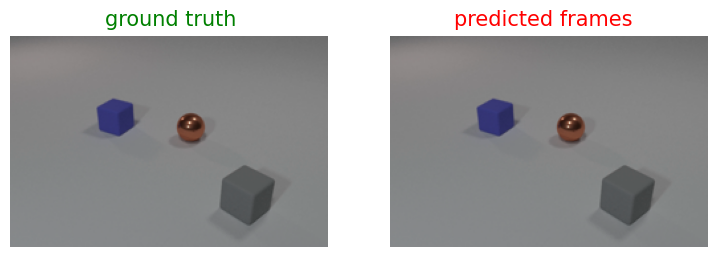

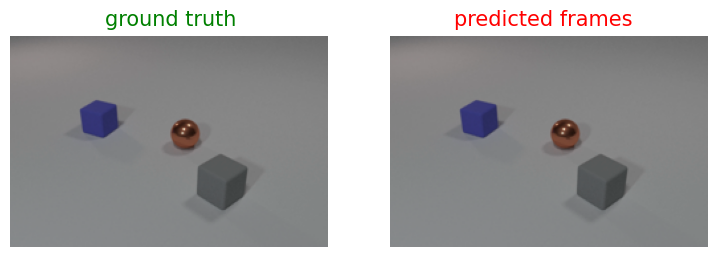

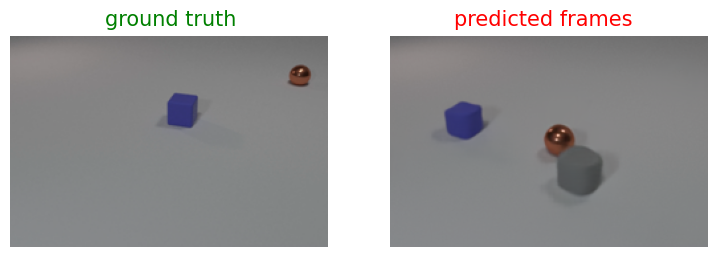

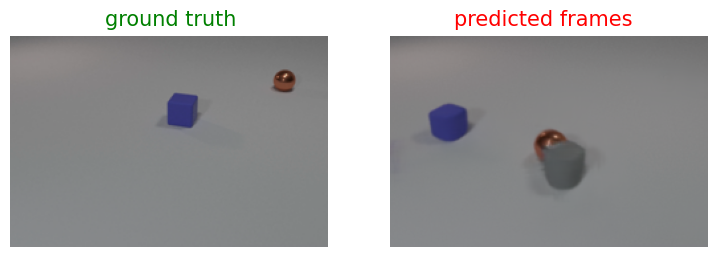

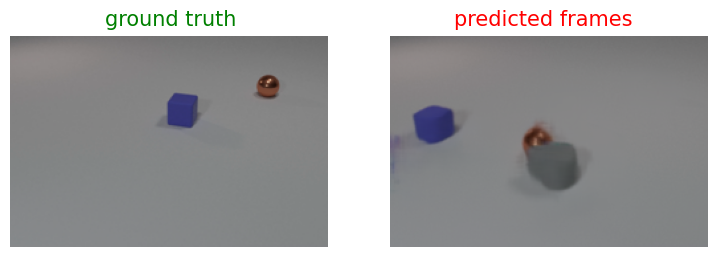

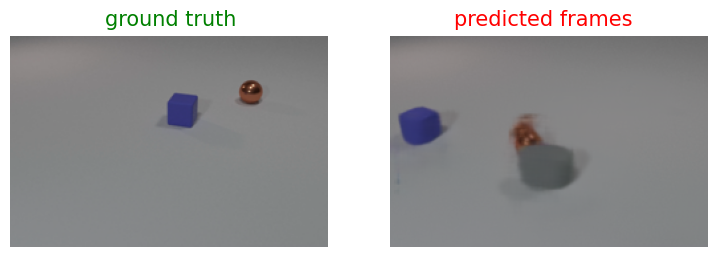

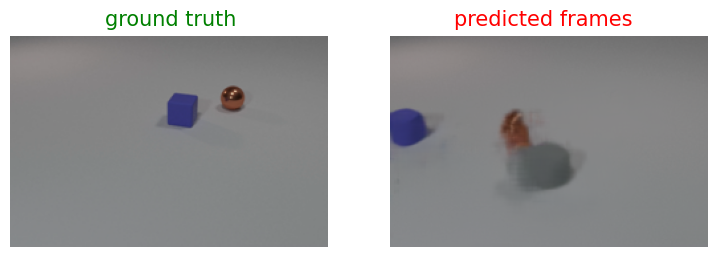

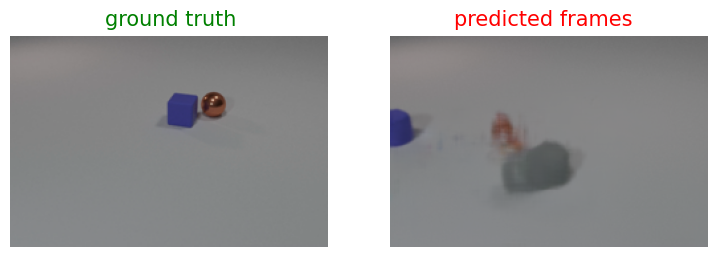

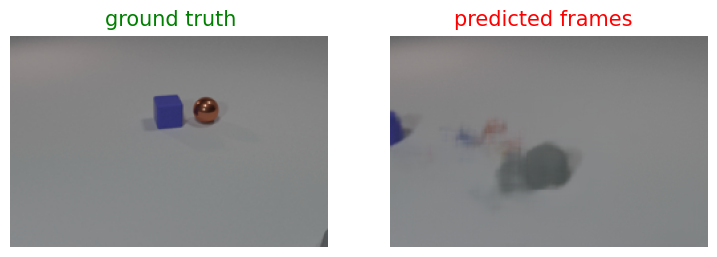

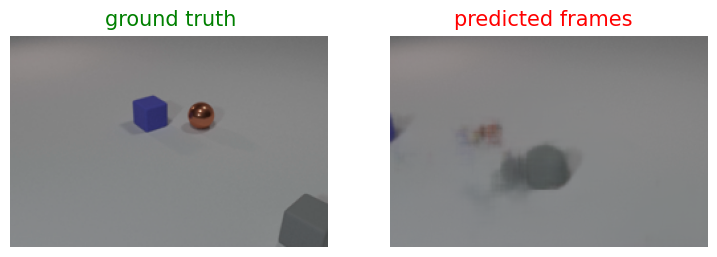

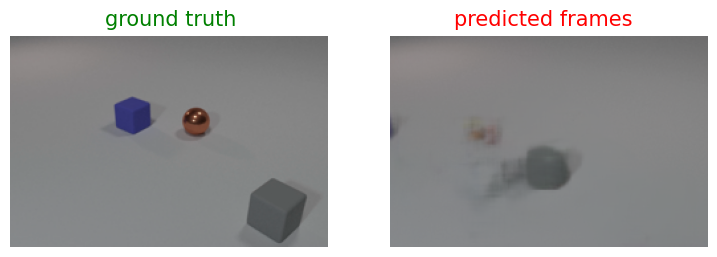

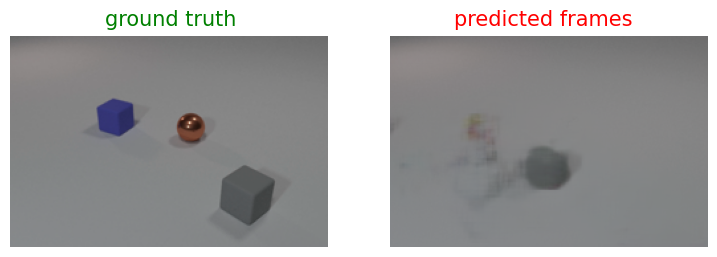

In [19]:
import numpy as np
from openstl.utils import show_video_line

# show the given frames from an example
inputs = np.load('./work_dirs/custom_exp/saved/inputs.npy')
preds = np.load('./work_dirs/custom_exp/saved/preds.npy')
trues = np.load('./work_dirs/custom_exp/saved/trues.npy')

example_idx = 0
show_video_line(trues[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)
show_video_line(preds[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

from openstl.utils import show_video_gif_multiple

example_idx = 0
show_video_gif_multiple(inputs[example_idx], trues[example_idx], preds[example_idx], use_rgb=True, out_path='example.gif')

# Model2 masked rcnn v2

In [20]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 5.2 MB/s eta 0:00:00


In [21]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor

In [22]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor

class VideoFrameDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.video_dirs = []

        for d in sorted(os.listdir(self.root_dir)):
            dir_path = os.path.join(self.root_dir, d)
            mask_path = os.path.join(dir_path, "mask.npy")
            # Only add to the video_dirs list if the directory exists and contains the mask.npy file
            if os.path.isdir(dir_path) and os.path.exists(mask_path):
                self.video_dirs.append(dir_path)

        if not self.video_dirs:
            raise RuntimeError("No valid directories found in the specified root_dir")

        self.num_videos = len(self.video_dirs)
        self.frames_per_video = len([name for name in os.listdir(self.video_dirs[0]) if name.endswith(".png")])

    def __len__(self):
        return self.num_videos * self.frames_per_video

    def __getitem__(self, idx):
        video_idx = idx // self.frames_per_video
        frame_idx = idx % self.frames_per_video

        video_dir = self.video_dirs[video_idx]
        img_name = os.path.join(video_dir, f"image_{frame_idx}.png")
        mask_name = os.path.join(video_dir, "mask.npy")

        image = Image.open(img_name).convert("RGB")
        masks = np.load(mask_name)
        mask = masks[frame_idx]

        # Get unique object labels from the mask
        obj_ids = np.unique(mask)
        # First ID is assumed to be background, so remove it
        obj_ids = obj_ids[1:]

        # Initialize masks, boxes, and labels
        num_objs = len(obj_ids)
        boxes = []
        labels = []
        masks_out = []

        for i, obj_id in enumerate(obj_ids):
            # Position of the object in the mask
            pos = np.where(mask == obj_id)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])

            # Ensure the dimensions of the bounding box are valid
            if xmin >= xmax or ymin >= ymax:
                continue

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.mask_value_to_label(obj_id))
            masks_out.append(mask == obj_id)


        boxes = torch.as_tensor(np.array(boxes), dtype=torch.float32)
        labels = torch.as_tensor(np.array(labels), dtype=torch.int64)
        masks_out = torch.as_tensor(np.array(masks_out), dtype=torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks_out
        # target['origin'] = mask

        if self.transform:
            image = self.transform(image)
        else:
            image = to_tensor(image)

        return image, target

    def mask_value_to_label(self, mask_value):
        return mask_value

train_dataset = VideoFrameDataset(root_dir='./Dataset_Student/train', transform=None)
val_dataset = VideoFrameDataset(root_dir='./Dataset_Student/val', transform=None)


In [23]:
from torch.utils.data import DataLoader

train_data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_data_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [24]:
###########for test
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, numpy_array):
        self.data = numpy_array

    def __len__(self):
        # Return the number of items in the dataset
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Select the 11th element of each sequence, index 10
        item = self.data[idx, 10]
        # Convert to a torch tensor
        return torch.tensor(item, dtype=torch.float)

# Load NumPy array
preds = np.load('./work_dirs/custom_exp/saved/preds.npy')

# Load Custom Dataset
test_dataset = CustomDataset(preds)

test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)





In [25]:
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
def create_maskrcnn_v2_model(num_classes):
    """
    Create an improved Mask R-CNN model with a ResNet-50-FPN v2 backbone.

    Args:
    num_classes (int): Number of classes including the background.

    Returns:
    A Mask R-CNN model with the specified number of classes.
    """
    # Create the Mask R-CNN model with a ResNet-50-FPN v2 backbone
    model = maskrcnn_resnet50_fpn_v2(num_classes=num_classes)

    return model
num_classes = 1 + 3 * 2 * 8
model = create_maskrcnn_v2_model(num_classes)

In [26]:
import torchmetrics

def mask_iou(mask1, mask2):
    """
    Calculate the Intersection over Union (IoU) between two masks using torchmetrics.

    Args:
    mask1 (numpy.ndarray): The first mask array of shape (H, W).
    mask2 (numpy.ndarray): The second mask array of shape (H, W).
    num_classes (int): The number of classes, including the background class.

    Returns:
    float: The IoU score between mask1 and mask2.
    """

    # Ensure that masks are on the same device
    mask1 = mask1.to(device)
    mask2 = mask2.to(device)
    # Convert numpy arrays to torch tensors
    mask1_tensor = torch.tensor(mask1, dtype=torch.int64)
    mask2_tensor = torch.tensor(mask2, dtype=torch.int64)

    # Create an instance of JaccardIndex
    jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49).to(device)

    # Compute the IoU score
    iou_score = jaccard(mask1_tensor, mask2_tensor)

    # Detach the IoU score from the computation graph and convert to a python number
    iou_score = iou_score.detach().cpu().item()

    return iou_score

## Start training

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

# Move the model to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define the number of epochs
num_epochs = 50

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.000001)

# Initialize a variable to track the maximum validation IOU
max_val_loss = 0

# Define a function for loading checkpoints
def load_checkpoint(model, optimizer, filename='latest_checkpoint.pth'):
    start_epoch = 0
    min_val_loss = 0  # Initialize maximum validation IOU
    if os.path.isfile(filename):
        print("Loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        min_val_loss = checkpoint['min_val_loss']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("Loaded checkpoint '{}' (epoch {})".format(filename, checkpoint['epoch']))
    else:
        print("No checkpoint found at '{}'".format(filename))
    return model, optimizer, start_epoch, min_val_loss

# Load the model and optimizer state (if it exists)
model, optimizer, start_epoch, max_val_loss = load_checkpoint(model, optimizer)


for epoch in range(num_epochs):
    if start_epoch != 0:
        epoch = start_epoch
    model.train()
    total_train_loss = 0

    with tqdm(train_data_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]', leave=False, ncols=75) as pbar:
        for images, targets_list in pbar:
            # Move images and targets to the correct device
            images = list(img.to(device) for img in images)
            targets = [{k: torch.as_tensor(v).to(device) if isinstance(v, np.ndarray) else v.to(device) for k, v in t.items()} for t in targets_list]

            # Forward pass through the model
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Zero the gradient before backward pass
            optimizer.zero_grad()
            losses.backward()

            # Update weights
            optimizer.step()

            total_train_loss += losses.item()
            pbar.set_postfix(loss=losses.item(), refresh=False)

    scheduler.step()
    avg_train_loss = total_train_loss / len(train_data_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    total_iou = 0
    num_samples = 0

    with torch.no_grad():
        for images, targets_list in tqdm(val_data_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]', leave=False, ncols=75):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets_list]

            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_masks = output["masks"] > 0.5  # Predicted masks
                true_masks = targets[i]["masks"]  # True masks

                for pred_mask, true_mask in zip(pred_masks, true_masks):
                    iou = mask_iou(pred_mask.squeeze(0), true_mask)
                    total_iou += iou
                    num_samples += 1


    avg_val_loss = total_iou / len(val_data_loader) if len(val_data_loader) > 0 else float('inf')

    # Check if the model should be saved
#     if avg_val_loss > max_val_loss:
#         max_val_loss = avg_val_loss
    torch.save(model.state_dict(), f'model_epoch_{epoch+1}_loss_{avg_val_loss:.4f}.pth')

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # Save the current epoch's model and optimizer state
    torch.save({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'min_val_loss': max_val_loss
    }, 'latest_checkpoint.pth')



## The following code is use to generate prediction result

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def combine_predicted_masks_with_labels(pred_masks, pred_labels):
    """
    Combine predicted masks into a single image with pixel values as labels.

    Args:
    pred_masks (torch.Tensor): The predicted masks tensor of shape (N, 1, H, W).
    pred_labels (np.ndarray): The predicted labels array of shape (N,).

    Returns:
    numpy.ndarray: Combined labeled mask image of shape (H, W).
    """
    # Initialize the combined mask with zeros, which represents the background
    combined_mask = np.zeros(pred_masks.shape[2:], dtype=np.int32)

    score_mask = np.zeros(pred_masks.shape[2:], dtype=np.float32)

    for label, mask, score in zip(pred_labels, pred_masks, pred_scores):
        # Convert the mask to a binary mask with a threshold (e.g., 0.5)
        binary_mask = mask[0] > 0.5  # Assuming the mask tensor has shape (1, H, W)

        # Update the combined mask where the current score is higher than the stored score
        update_mask = binary_mask & (score > score_mask)
        combined_mask[update_mask] = label
        score_mask[update_mask] = score

    return combined_mask

def visualize_combined_mask(combined_mask):
    """
    Visualize the combined mask with a colormap.

    Args:
    combined_mask (numpy.ndarray): Combined labeled mask image of shape (H, W).
    """
    # Choose a colormap that provides distinct colors for each label
    # colormap = plt.cm.get_cmap('tab20', np.max(combined_mask) + 1)

    # Display the combined mask using the colormap
    plt.figure(figsize=(10, 10))
    plt.imshow(combined_mask)
    # plt.axis('off')
    plt.show()


# prediction = [{k: v.cpu().numpy() if isinstance(v, torch.Tensor) else v for k, v in pred.items()} for pred in prediction]

# # Assuming you have your predictions from the model
# pred_masks = prediction[0]['masks']  # Tensor of shape (17, 1, 160, 240)
# pred_labels = prediction[0]['labels']  # Array of shape (17,)
# pred_scores = prediction[0]['scores']

# # Move predicted masks to CPU and convert to numpy if necessary
# if isinstance(pred_masks, torch.Tensor):
#     pred_masks = pred_masks.cpu().numpy()

# # Combine the predicted masks into a single mask image
# combined_mask = combine_predicted_masks_with_labels(pred_masks, pred_labels)

# # Visualize the combined mask
# visualize_combined_mask(combined_mask)

###Need to edit the model file name here to load the correct model


Testing:   0%|                                       | 0/2 [00:00<?, ?it/s]

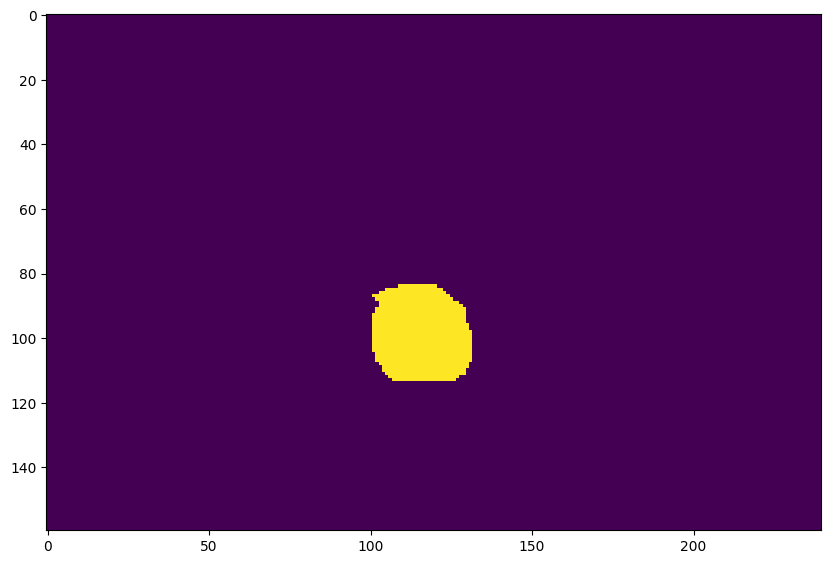

Testing:  50%|███████████████▌               | 1/2 [00:03<00:03,  3.86s/it]

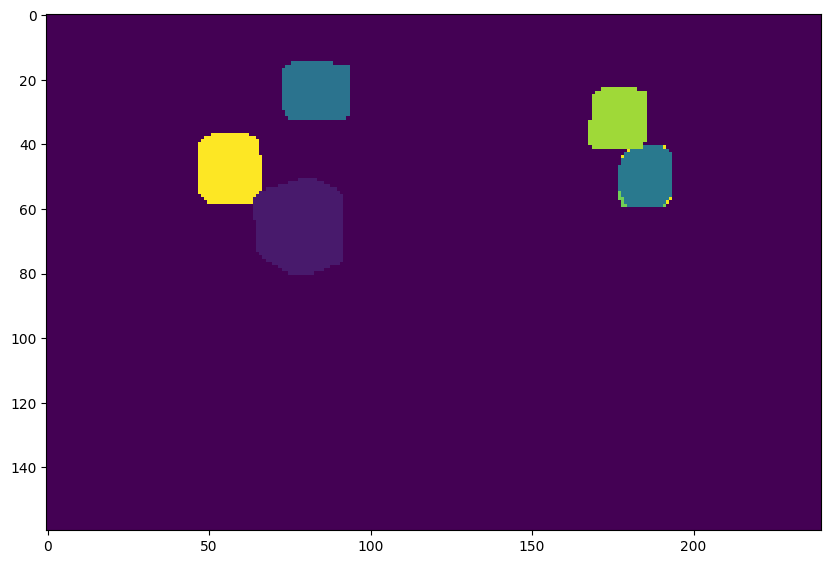

Testing: 100%|███████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]

Shape of predicted masks: (2, 160, 240)
Predicted masks saved to predicted_masks.npy


In [28]:
from tqdm import tqdm

model = create_maskrcnn_v2_model(num_classes)

# Edit the model file name here
model.load_state_dict(torch.load(rcnnmodelfile))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.eval()
predicted_masks = []

with torch.no_grad():
    for images in tqdm(test_data_loader, desc='Testing', ncols=75):
        images = images.to(device)

        outputs = model(images)

        prediction = [{k: v.cpu().numpy() if isinstance(v, torch.Tensor) else v for k, v in pred.items()} for pred in outputs]

        pred_masks = prediction[0]['masks']  # Tensor of shape (17, 1, 160, 240)
        pred_labels = prediction[0]['labels']  # Array of shape (17,)
        pred_scores = prediction[0]['scores']

        if isinstance(pred_masks, torch.Tensor):
            pred_masks = pred_masks.cpu().numpy()

        combined_mask = combine_predicted_masks_with_labels(pred_masks, pred_labels)
        visualize_combined_mask(combined_mask)

        predicted_masks.append(combined_mask)

# Stack all predicted masks into a single NumPy array
predicted_masks = np.stack(predicted_masks, axis=0)

# Verify the shape of the final result
print("Shape of predicted masks:", predicted_masks.shape)

filename = 'predicted_masks.npy'

# Save the predicted masks to a .npy file
np.save(filename, predicted_masks)

print(f"Predicted masks saved to {filename}")